# LIBRARIES

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE

# LOAD IMAGES

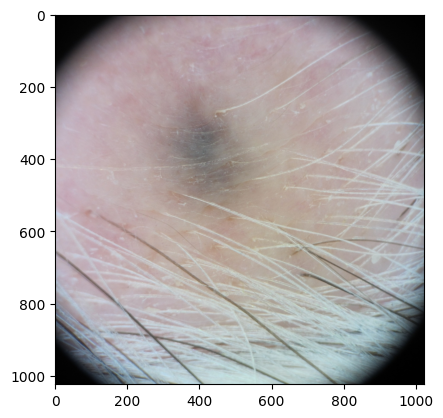

In [ ]:
path_train = 'nev00010.jpg'
image_read = cv2.imread(path_train)
image_show = plt.imshow(cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB))

# 1_PRE-PROCESSING
---
*   Resizing
*   Noise removal
*   Contrast stretching
*   Hair removal (bottom-hat filtering)
*   Enhaced image to gray





Enhanced Gray Image is Grayscale
Statistics for Enhanced Gray Image:
Minimum Value: 0
Mean Value: 158.63935375213623
Maximum Value: 234

Statistics for Hair-Removed Image:
Minimum Value: 0
Mean Value: 191.9636888888889
Maximum Value: 255



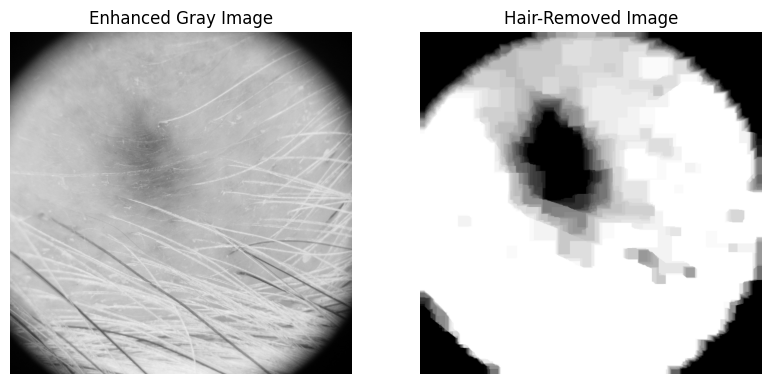

In [ ]:
# Load the image
# path_train = 'nev00010.jpg'
# image_read = cv2.imread(path_train)
# image_gray = cv2.cvtColor(image_read, cv2.COLOR_BGR2GRAY)

# Function to print image statistics
def print_image_statistics(image, label):
    print(f"Statistics for {label} Image:")
    print(f"Minimum Value: {np.min(image)}")
    print(f"Mean Value: {np.mean(image)}")
    print(f"Maximum Value: {np.max(image)}")
    print()

# Function to perform contrast stretching
def contrast_stretching(image):
    avg = np.mean(image)
    std_dev = np.std(image)
    low_in = avg - 0.4 * std_dev
    high_in = avg + 0.4 * std_dev

    # Clip and scale intensity values to the range [0, 255]
    stretched_image = np.clip((image - low_in) / (high_in - low_in) * 255, 0, 255).astype(np.uint8)

    return stretched_image

# Function to perform hair removal using bottom-hat filtering
def remove_hair(image):
    # Convert the grayscale image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Convert the RGB image to HSV color space
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # Define a lower and upper threshold for the hair color in HSV
    lower_hair = np.array([0, 20, 70], dtype=np.uint8)
    upper_hair = np.array([20, 255, 255], dtype=np.uint8)

    # Create a mask using the inRange function
    mask_hair = cv2.inRange(hsv, lower_hair, upper_hair)

    # Apply bottom-hat filtering
    kernel = np.ones((15, 15), np.uint8)
    bottom_hat = cv2.morphologyEx(image_rgb, cv2.MORPH_BLACKHAT, kernel)

    # Combine the original image and the bottom-hat result
    result_hair_removed = cv2.add(image_rgb, bottom_hat)

    # Use morphological operations to further refine hair removal
    kernel = np.ones((15, 15), np.uint8)
    result_hair_removed = cv2.morphologyEx(result_hair_removed, cv2.MORPH_OPEN, kernel, iterations=2)

    return result_hair_removed

# Resize the image to 767x1022
image_resized = cv2.resize(image_gray, (600, 600))

# Noise removal with a 3x3 median filter
image_noise_removed = cv2.medianBlur(image_resized, 3)

# Contrast stretching on the grayscale image
image_contrast_stretched = contrast_stretching(image_noise_removed)

# Hair removal using bottom-hat filtering
hair_removed_image = remove_hair(image_contrast_stretched)

# Convert enhanced image to gray
enhanced_gray_image = cv2.cvtColor(image_read, cv2.COLOR_BGR2GRAY)

# Print image type information
if len(enhanced_gray_image.shape) == 2:
    print("Enhanced Gray Image is Grayscale")
elif len(enhanced_gray_image.shape) == 3 and enhanced_gray_image.shape[2] == 3:
    print("Enhanced Gray Image is RGB")
elif len(enhanced_gray_image.shape) == 3 and enhanced_gray_image.shape[2] == 1:
    print("Enhanced Gray Image is Binary")

# Print statistics for Enhanced Gray Image
print_image_statistics(enhanced_gray_image, 'Enhanced Gray')

# Print statistics for Hair-Removed Image
print_image_statistics(hair_removed_image, 'Hair-Removed')

# Plotting the segmentation results
# plt.figure(figsize=(15, 6))

# # Enhanced gray image
# plt.subplot(1, 3, 1)
# plt.imshow(enhanced_gray_image, cmap='gray')
# plt.title('Enhanced Gray Image')
# plt.axis('off')

# # Hair removal result
# plt.subplot(1, 3, 2)
# plt.imshow(hair_removed_image)
# plt.title('Hair-Removed Image')
# plt.axis('off')

# plt.show()

# 2_SEGMENTATION

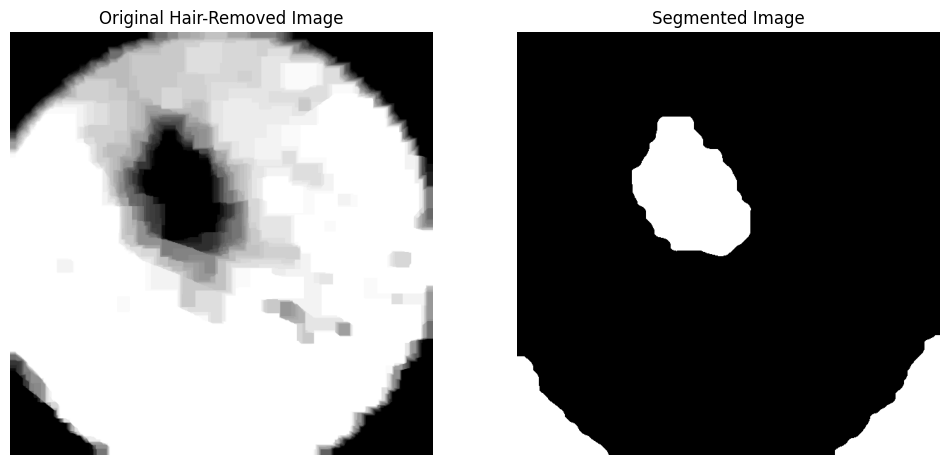

In [ ]:
# Convert the hair-removed image to grayscale
hair_removed_gray = cv2.cvtColor(hair_removed_image, cv2.COLOR_RGB2GRAY)

# Apply GaussianBlur to the grayscale image
blurred = cv2.GaussianBlur(hair_removed_gray, (5, 5), 0)

# Perform OTSU's thresholding
_, thresholded_image = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Remove background triangles by creating a mask
background_mask = np.zeros_like(thresholded_image)
background_mask[:30, :] = 255  # Assuming the triangles are in the top part of the image
thresholded_image_no_triangles = cv2.bitwise_and(thresholded_image, thresholded_image, mask=cv2.bitwise_not(background_mask))

# Invert the image to make the skin lesion white and the background black
inverted_image = cv2.bitwise_not(thresholded_image_no_triangles)

# Flood fill operation on 4-connected pixels in the background to remove holes
h, w = inverted_image.shape[:2]
mask = np.zeros((h + 2, w + 2), np.uint8)
cv2.floodFill(inverted_image, mask, (0, 0), 0)

# Perform morphological opening to remove small objects (fewer than 2000 pixels)
kernel_opening = np.ones((5, 5), np.uint8)
segmented_image = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel_opening, iterations=1)

# Lesion border smoothening using opening and closing operations
kernel_smoothing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))
segmented_image_smoothed = cv2.morphologyEx(segmented_image, cv2.MORPH_OPEN, kernel_smoothing, iterations=1)
segmented_image_smoothed = cv2.morphologyEx(segmented_image_smoothed, cv2.MORPH_CLOSE, kernel_smoothing, iterations=1)

# Display the original hair-removed image and the segmented result
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.imshow(hair_removed_image)
# plt.title('Original Hair-Removed Image')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(segmented_image_smoothed, cmap='gray')
# plt.title('Segmented Image')
# plt.axis('off')

# plt.show()

# Attemp for machine learning

In [ ]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split

# # Define the directory containing segmented images
# segmented_directory = 'path/to/segmented/images'  # Replace with the actual path

# # Initialize lists to store features and labels
# features = []
# labels = []

# # Function to extract features from an image (replace with your feature extraction method)
# def extract_features_from_image(image):
#     # Preprocess and extract features (replace this with your actual feature extraction code)
#     # For example, you can use img = preprocess_and_extract_features(img)
#     return img_features

# # Process segmented images and assign labels
# for filename in os.listdir(segmented_directory):
#     image_path = os.path.join(segmented_directory, filename)
#     img = cv2.imread(image_path)
#     img_features = extract_features_from_image(img)

#     # Determine the label based on the directory structure
#     if "nevus" in image_path.lower():
#         label = 1  # Positive label
#     elif "others" in image_path.lower():
#         label = 0  # Negative label
#     else:
#         continue  # Skip images in other folders

#     # Append features and labels to their respective lists
#     features.append(img_features)
#     labels.append(label)

# # Convert lists to NumPy arrays
# features = np.array(features)
# labels = np.array(labels)

# # Split the combined array into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# # Now, X_train and y_train contain training data, and X_val and y_val contain validation data
